In [119]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# Checking package versions to trouble shoot error messages
import sklearn
print(sklearn.__version__)

1.2.2


In [121]:
# Not using all of these but importing all just incase
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools
from tqdm import tqdm
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

## **Downloading the data**

In [122]:
import os

# List contents of My Drive
drive_path = '/content/drive/MyDrive/archive'
os.listdir(drive_path)

['HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'SequentialCNNandLatentNet.ipynb',
 'DenseNet.ipynb']

In [123]:
# Importing the data
df = pd.read_csv('/content/drive/MyDrive/archive/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [124]:
# Checking data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [125]:
from glob import glob
base_skin_dir = '/content/drive/MyDrive/archive/'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [126]:
# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [127]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back,/content/drive/MyDrive/archive/HAM10000_images...,Benign keratosis-like lesions,2


In [128]:
# Data Cleaning - Checking for Missing Values
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [129]:
# Since all missing values are in the age column I am just filling with the mean
df['age'].fillna((df['age'].mean()), inplace=True)

# Checking that all the missing values have been taken care of
df.isna().sum().sum()

0

In [130]:
# Define a function to resize images in batches (originally did not use batch processing but the computational load was too big for my computer)
def resize_images_in_batch(image_paths, size=(100, 75)):
    resized_images = []
    for path in image_paths:
        img = np.asarray(Image.open(path).resize(size))
        resized_images.append(img)
    return np.array(resized_images)

In [131]:
# Resizing images in batches (to reduce processing time when it comes to applying the model)
image_paths = df['path'].tolist()
batch_size = 100  # May need to adjust based on your individual memory constraints if you want to run this

# Process and store resized images
resized_images = []
for i in tqdm(range(0, len(image_paths), batch_size), desc="Resizing Images"):
    batch = image_paths[i:i + batch_size]
    resized_images.extend(resize_images_in_batch(batch))

# Adding resized images to the DataFrame
df['image'] = resized_images

Resizing Images: 100%|██████████| 101/101 [03:02<00:00,  1.81s/it]


##Exploratory Data Analysis##

In [132]:
# A sample of the pictoral representation of the images as a sanity check (including images from each class as this is a multiclassification analysis)
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Output hidden; open in https://colab.research.google.com to view.

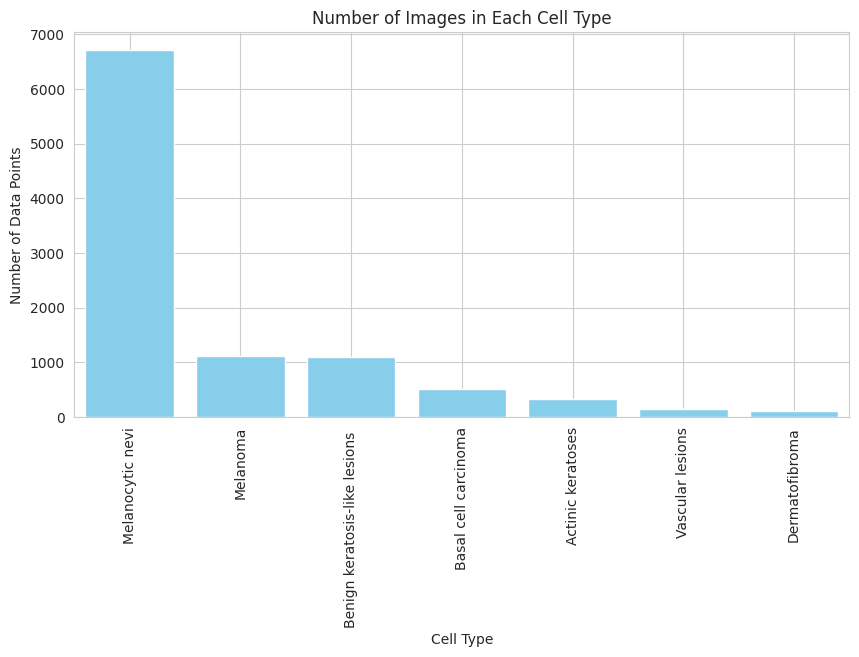

In [133]:
#Visualize the amount of images cateogrized under each cell type
# Count the number of data points in each category
category_counts = df['cell_type'].value_counts()
# plt.figure(figsize=(16, 8))
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

# Plot a bar graph
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Cell Type')
plt.ylabel('Number of Data Points')
plt.title('Number of Images in Each Cell Type')
plt.show()

<Axes: xlabel='age', ylabel='count'>

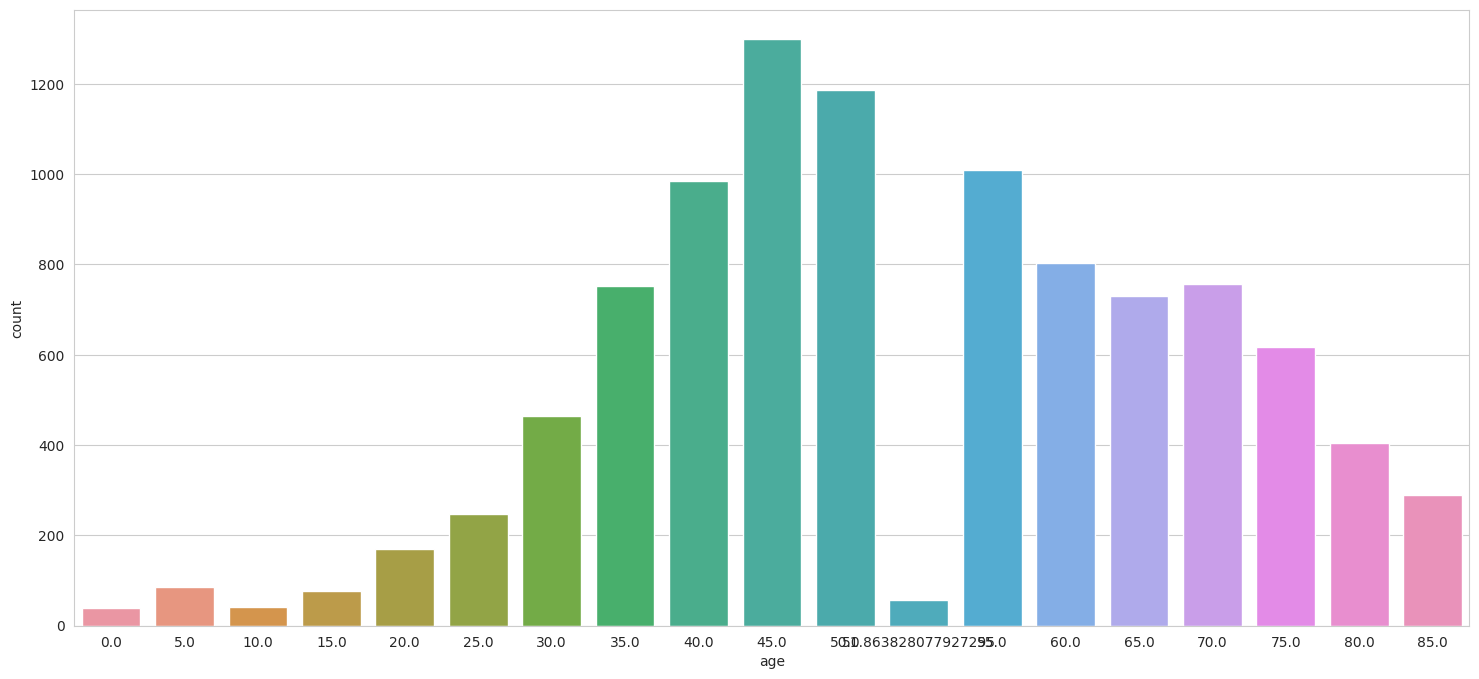

In [134]:
#Plot to see distribution of ages over dataset
plt.figure(figsize=(18, 8))
sns.countplot(x='age', data=df)

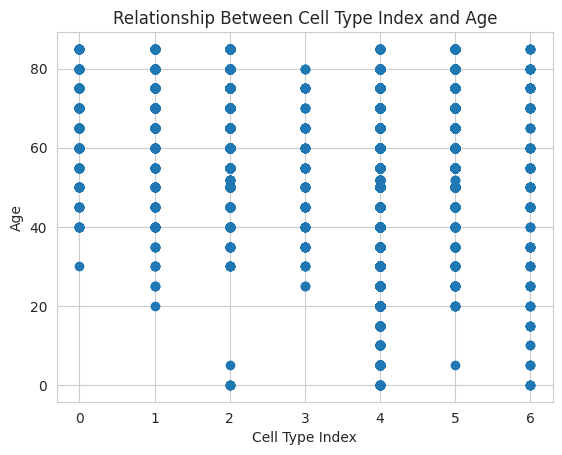

In [135]:
plt.scatter(df['cell_type_idx'], df['age'])
plt.xlabel('Cell Type Index')
plt.ylabel('Age')
plt.title('Relationship Between Cell Type Index and Age')
plt.show()

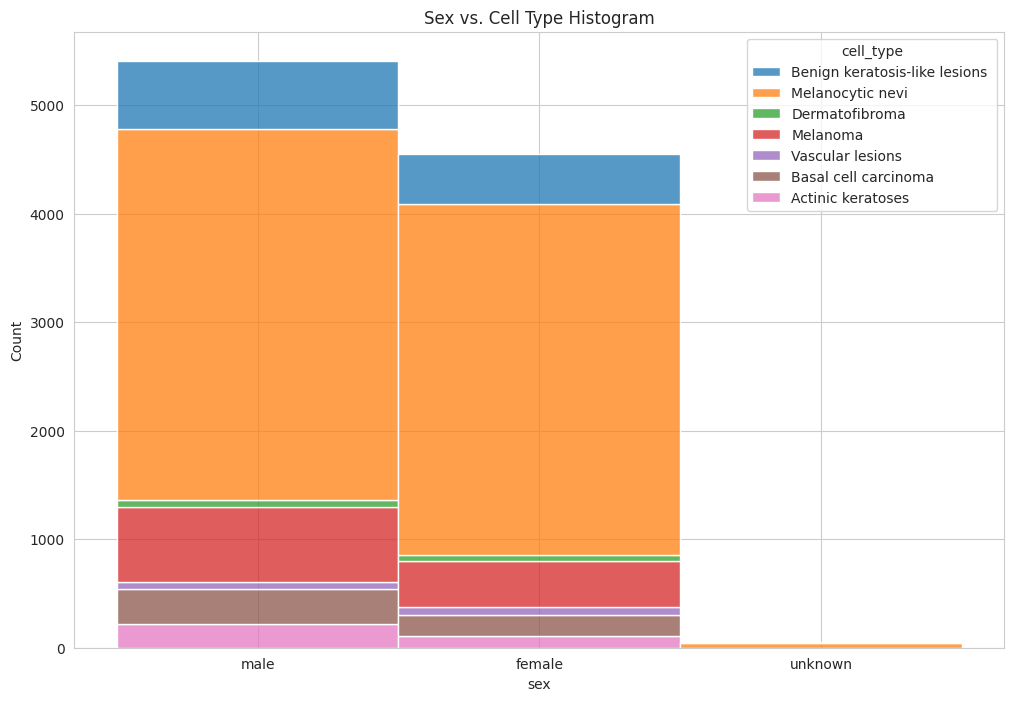

In [136]:
#Plot Sex versus cell type
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='sex',hue='cell_type',multiple='stack')
plt.title('Sex vs. Cell Type Histogram')
plt.show()

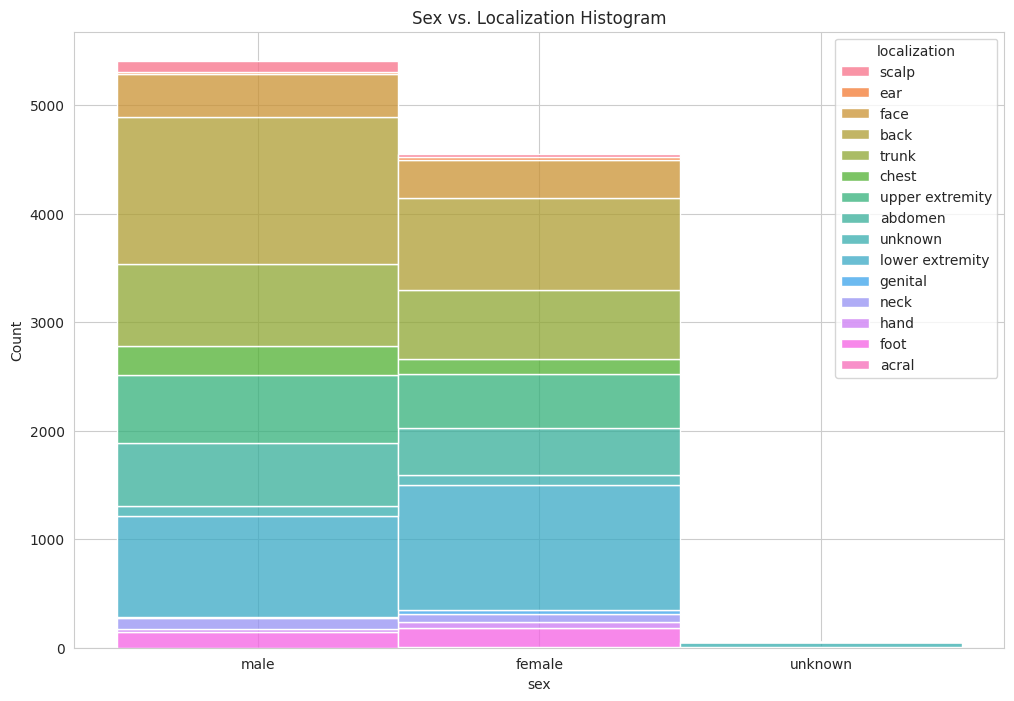

In [137]:
#Plot Sex vs. Localization
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='sex',hue='localization',multiple='stack')
plt.title('Sex vs. Localization Histogram')
plt.show()

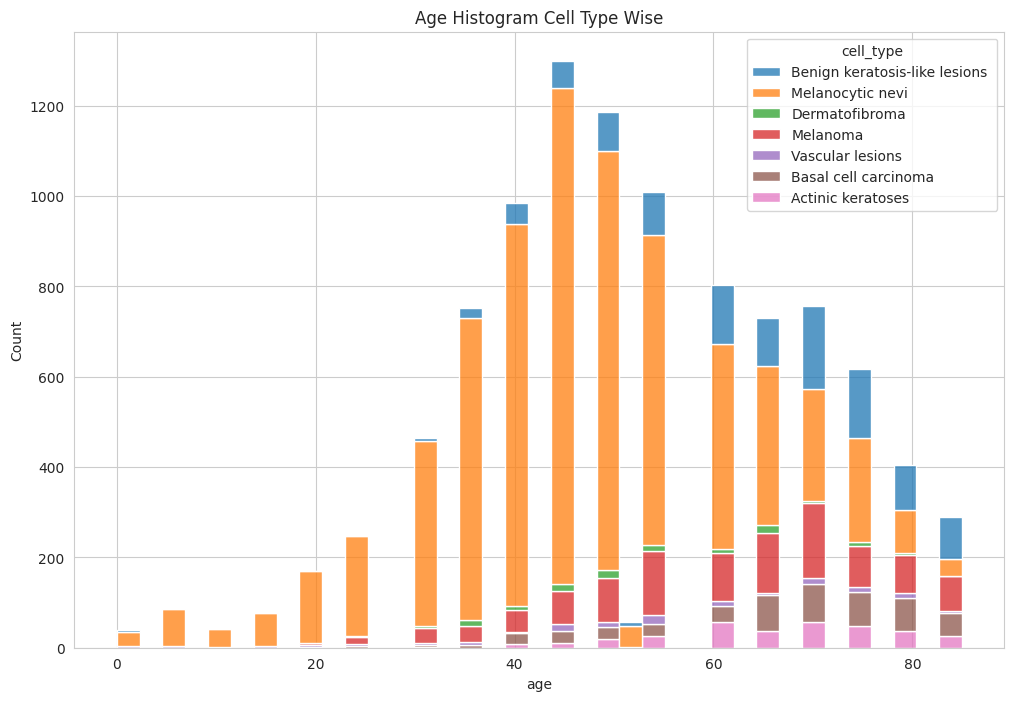

In [138]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='cell_type',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

<ipython-input-140-ec1ad19f6302>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


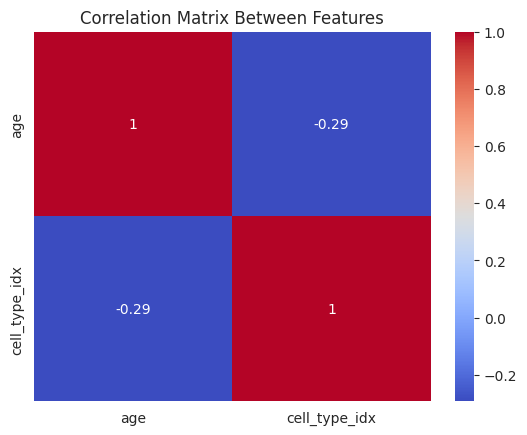

In [140]:
#Visualize relationship between different features using heat maps and pair plots
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Matrix Between Features')
plt.show()

##Plot the average image over the dataset##

In [141]:
rgb_file_path = base_skin_dir + "hmnist_28_28_RGB.csv"
print(rgb_file_path)

df_rgb = pd.read_csv(rgb_file_path)
df_rgb.head()

/content/drive/MyDrive/archive/hmnist_28_28_RGB.csv


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [142]:
# Load RGB values from the file
file_path = base_skin_dir + "hmnist_28_28_RGB.csv"
print(file_path)

# Extract RGB values from each line and convert to NumPy array
rgb = pd.read_csv(file_path)
rgb_columns = rgb.iloc[:, :-1].values
rgb_array = np.array(rgb_columns, dtype=np.uint8)

# Calculate the average RGB values
average_rgb = np.mean(rgb_array, axis=0).astype(np.uint8)

# Print the average RGB values
print("Average RGB Values:", average_rgb)
print(len(average_rgb))

/content/drive/MyDrive/archive/hmnist_28_28_RGB.csv
Average RGB Values: [181 131 141 ... 172 127 133]
2352


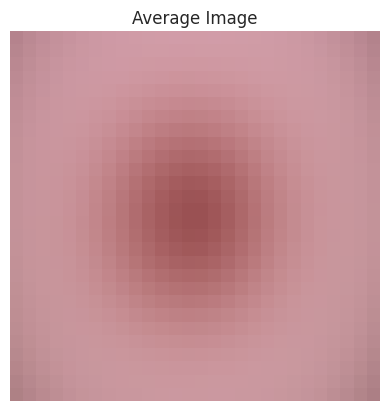

In [143]:
# Reshape the average RGB values into the shape of an image
average_image = average_rgb.reshape(28, 28, 3)

# Display the average image using imshow
plt.imshow(average_image)
plt.axis('off')
plt.title("Average Image")
plt.show()

[[ 11  22  52 ...  13  27  44]
 [100 139 145 ... 109 143 150]
 [ 11   7  12 ... 220 233 240]
 ...
 [207 243 233 ...   0  24  12]
 [235 249   5 ...  13  35  39]
 [250  11 236 ...   3  12 249]]


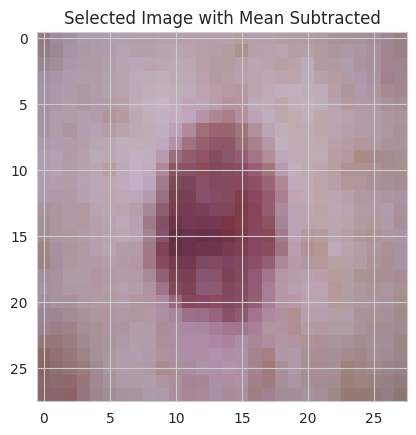

In [149]:
#Subtract the mean image from the other images
mean_subtract = rgb_array - average_rgb
print(mean_subtract)

#Index chosen at random
selected_face = rgb_array[50].reshape(28, 28, 3)

#Plot a randomly selected image with the mean subtracted
plt.imshow(selected_face)
plt.title('Selected Image with Mean Subtracted')
plt.show()

##Split into Training and Test##

In [145]:
# Setting the target variable
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [146]:
# Splitting the dataset into training and testing set
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [147]:
# One hot encoding categorical features
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [148]:
# Normalization of images for increased accuracy and decreasd training time
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std